In [13]:
import os
import gc   # garbage collector
import pandas as pd
import numpy as np

import rioxarray as rioxr

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

In [2]:
# **************************************************************
root = '/home/jovyan/msai4earth-esa/iceplant_detection/models/model_2k/twok_dataset/dataset_2500/'
train_name = 'glcm_train_2500.csv'
test_name = 'glcm_test_2500.csv'

label_name = 'iceplant'

# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name))
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 
y_train = y_train.to_numpy()

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name))
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 
y_test = y_test.to_numpy()

In [3]:
# =====================================================
# Conception
box_conc = Polygon([
            [-120.460475016992,34.458719091893286],
            [-120.460475016992,34.457914336783816],
            [-120.4595085784309,34.457914336783816],
            [-120.4595085784309,34.458719091893286],
            [-120.460475016992,34.458719091893286]
          ])

itemid_conc = 'ca_m_3412037_nw_10_060_20200607'
# =====================================================
# Downtown Santa Barbara
box_dtwn = Polygon([
            [-119.68421454977785,34.41470061879498],
            [-119.68421454977785,34.413873204306356],
            [-119.68319471307942,34.413873204306356],
            [-119.68319471307942,34.41470061879498],
            [-119.68421454977785,34.41470061879498]
          ])
itemid_dtwn = 'ca_m_3411935_se_11_060_20200521'

# =====================================================
# Carpinteria

box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

# =====================================================
# Campus lagoon

box_campus = Polygon([
            [-119.84498486537822,34.405839218897256],
            [-119.84498486537822,34.40505175972115],
            [-119.84395933515827,34.40505175972115],
            [-119.84395933515827,34.405839218897256],
            [-119.84498486537822,34.405839218897256]
          ])
itemid_campus = 'ca_m_3411934_sw_11_060_20200521'

In [4]:
# Load rasters

boxes = [box_conc, box_campus, box_carp, box_dtwn]
itemids = [itemid_conc, itemid_campus, itemid_carp, itemid_dtwn]

# I already knew the aois are at least 150x150 pixels
rasters = []
for itemid, box in zip(itemids, boxes):
    rasters.append(sr.rioxr_from_itemid(itemid, box, "EPSG:4326")[:,0:150,0:150])


fig, ax = plt.subplots(1,4,figsize=(30, 20))  
for i in range(4):
    ax[i].imshow(np.moveaxis(rasters[i].loc[1:3].to_numpy(),0,-1))
plt.show()

In [34]:
raster = rasters[0]
# input: raster, cols
# radius of the disk (in pixels) over which entropy is calculated
entropy_r = 6
# length of side of the square window over which average/max/min are calculated.

def classify_iceplant_texture(raster, rfc, cols, entropy_r):

    box_side = entropy_r *2 +1
    uses_ndvi = True
    verbose = False
    # ***********************************************************************************************
    # *************************************** PRE-PROCESSING ****************************************

    # find vegetation pixels to go into model
    # keep indices of water and low-ndvi pixels
    # add ndvi and ndwi features for each pixel
    is_veg, water_index, not_veg_index = sr.add_spectral_features(df=sr.raster_as_df(raster.to_numpy(), ['r','g','b','nir']), #names of bands
                                                               ndwi_thresh = 0.3, 
                                                               ndvi_thresh = 0.05) 
    if verbose:
        print('selected vegetation pixels')

    # ---------------------------------------
    # discard ndwi and add date features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = sr.add_date_features(is_veg, raster.datetime)

    # *************************************************************************************************
    # ******************************** CREATE R,G,B,NIR AUXILIARY RASTERS *****************************
    # make auxiliary spectral rasters from clipped NAIP 
    band_names = ['r_', 'g_', 'b_', 'nir_']
    tags = ['_avgs', '_entrs']
    window_fps = []
    window_cols = []

    for name, band in zip(band_names,range(1,5)):
        rast_name = name+itemid

        for tag in tags:
            rast_fp = os.path.join(os.getcwd(), 'temp', rast_name + tag + '.tif')
            window_fps.append(rast_fp)        
            window_cols.append( name.replace('_','')+tag.replace('s',str(box_side)))

            if os.path.isfile(rast_fp) == False:
                if tag == '_avgs':
                    sr.avg_raster(raster = raster, band=band, rast_name=rast_name, n=box_side)                            
                elif tag == '_entrs':
                    sr.entropy_raster(raster=raster, band=band, rast_name=rast_name, n=entropy_r)

    if verbose:
        print('created/verified R,G,B,NIR auxiliary rasters (avgs, entr)')

    # ********************************************************************************************
    # ******************************** CREATE NDVI AUXILIARY RASTERS *****************************
    if uses_ndvi:
        # make auxiliary NDVI from clipped NAIP 
        ndvi = sr.ndvi_xarray(raster)
        band_names.append('ndvi_')
        rast_name = 'ndvi_'+itemid

        for tag in tags:
            rast_fp = os.path.join(os.getcwd(), 'temp', rast_name + tag + '.tif')
            window_fps.append(rast_fp)        
            window_cols.append('ndvi' + tag.replace('s',str(box_side)))                

            if os.path.isfile(rast_fp) == False:
                if tag == '_avgs':
                    sr.avg_raster(rast_data=ndvi, 
                                  crs=raster.rio.crs, 
                                  transf=raster.rio.transform(), 
                                  rast_name=rast_name, 
                                  n=box_side)
                elif tag == '_entrs':
                    # adjusting to entropy input types
                    ndvi = ndvi*100+100  
                    sr.entropy_raster(rast_data=ndvi.astype('uint8'), 
                                      crs=raster.rio.crs, 
                                      transf=raster.rio.transform(), 
                                      rast_name=rast_name, 
                                      n=entropy_r)
        if verbose:
            print('created/verified NDVI auxiliary rasters (avgs,entr)')
        #free memory
        del ndvi
        gc.collect()

    # *******************************************************************************************
    # *********************** EXTRACT FEATURES FROM AUXILIARY RASTERS ***************************
    window_values = []    
    for fp_aux in window_fps:
        match = rioxr.open_rasterio(fp_aux).squeeze()
        match_vector = match.to_numpy().reshape(match.shape[0]*match.shape[1])
        window_values.append(match_vector)
        #delete_aux_rasters:
        os.remove(fp_aux)

    df_window = pd.DataFrame(dict(zip( window_cols, window_values)))

    scene_features = pd.concat([is_veg, df_window.iloc[is_veg.index]], axis=1)

    # **********************************************************************************************
    # *************** REMOVE NA VALUES (PIXELS AT EDGE OF CLIPPED PART OF RASTER) ******************
    # combine indices for r_min == 0 and ndvi_min == nan, ndvi_avg == nan

    # **** THIS NEEDS TO BE NOT HARDCODED: r_min11 and ndvi_min11 ****
    remove = set()
    if '_min' in tags:
        remove = scene_features.r_min11[scene_features.r_min11 == 0].index
    if uses_ndvi:
        for band in [x.replace('s',str(box_side)) for x in ['ndvi'+ y for y in tags]]:
            remove = remove.union(scene_features[band][scene_features[band].isna() == True].index)
    # remove these indices from scene_features
    # no need to add them anywhere else, they will be part of the raster's background
    scene_features = scene_features.drop(remove)

    #free memory            
    del df_window, window_values, match_vector, match, remove
    gc.collect()  

    # ******************************************************************************
    # ******************************** ORDER FEATURES ****************************** 

    scene_features = scene_features[cols]
    if verbose:
        print('finished assembling features')
    scene_features

    # ***********************************************************************************************
    # *************************************** CLASSIFICATION ****************************************
    #  predict using model
    scene_preds = rfc.predict(np.array(scene_features))
    if verbose:
        print('finished classification')

    # ************************************************************************************************
    # *************************************** POST-PROCESSING ****************************************
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(scene_preds, 
                         columns=['is_iceplant'], 
                         index = scene_features.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              3,
              3]
    reconstruct = sr.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)

    if verbose:
        print('finished post-processing')

    if verbose:
        print('FINISHED')  
    return reconstruct

In [24]:
classify_iceplant_texture(raster, rfc, cols, entropy_r)

selected vegetation pixels
created/verified R,G,B,NIR auxiliary rasters (avgs, entr)
created/verified NDVI auxiliary rasters (avgs,entr)
finished assembling features
finished classification
finished post-processing
FINISHED


array([[0., 3., 3., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [44]:
# feats is only a vector with the labels for the different models
images = []
#radii = [1,4,7,10,13]
radii = [x for x in range(1,14)]
# ------------------------------
bands = ['r','g','b','nir','ndvi']
texture_features = ['avg','entr']


In [45]:
for entropy_r in radii:
    box_side = entropy_r*2 +1
    cols = ['r','g','b','nir','month', 'day_in_year'] + (
           [band + '_'+ ft + str(box_side) for band in bands for ft in texture_features])
    
    X_train_sub = X_train[cols].to_numpy()
    X_test_sub = X_test[cols].to_numpy()    

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfc.fit(X_train_sub, y_train)

    this_model_imgs =[]
    for raster in rasters:
        this_model_imgs.append(classify_iceplant_texture(raster, rfc, cols, entropy_r))

    images.append(this_model_imgs)
    print('done with ', str(box_side))
    

done with  3
done with  5
done with  7
done with  9
done with  11
done with  13
done with  15
done with  17
done with  19
done with  21
done with  23
done with  25
done with  27


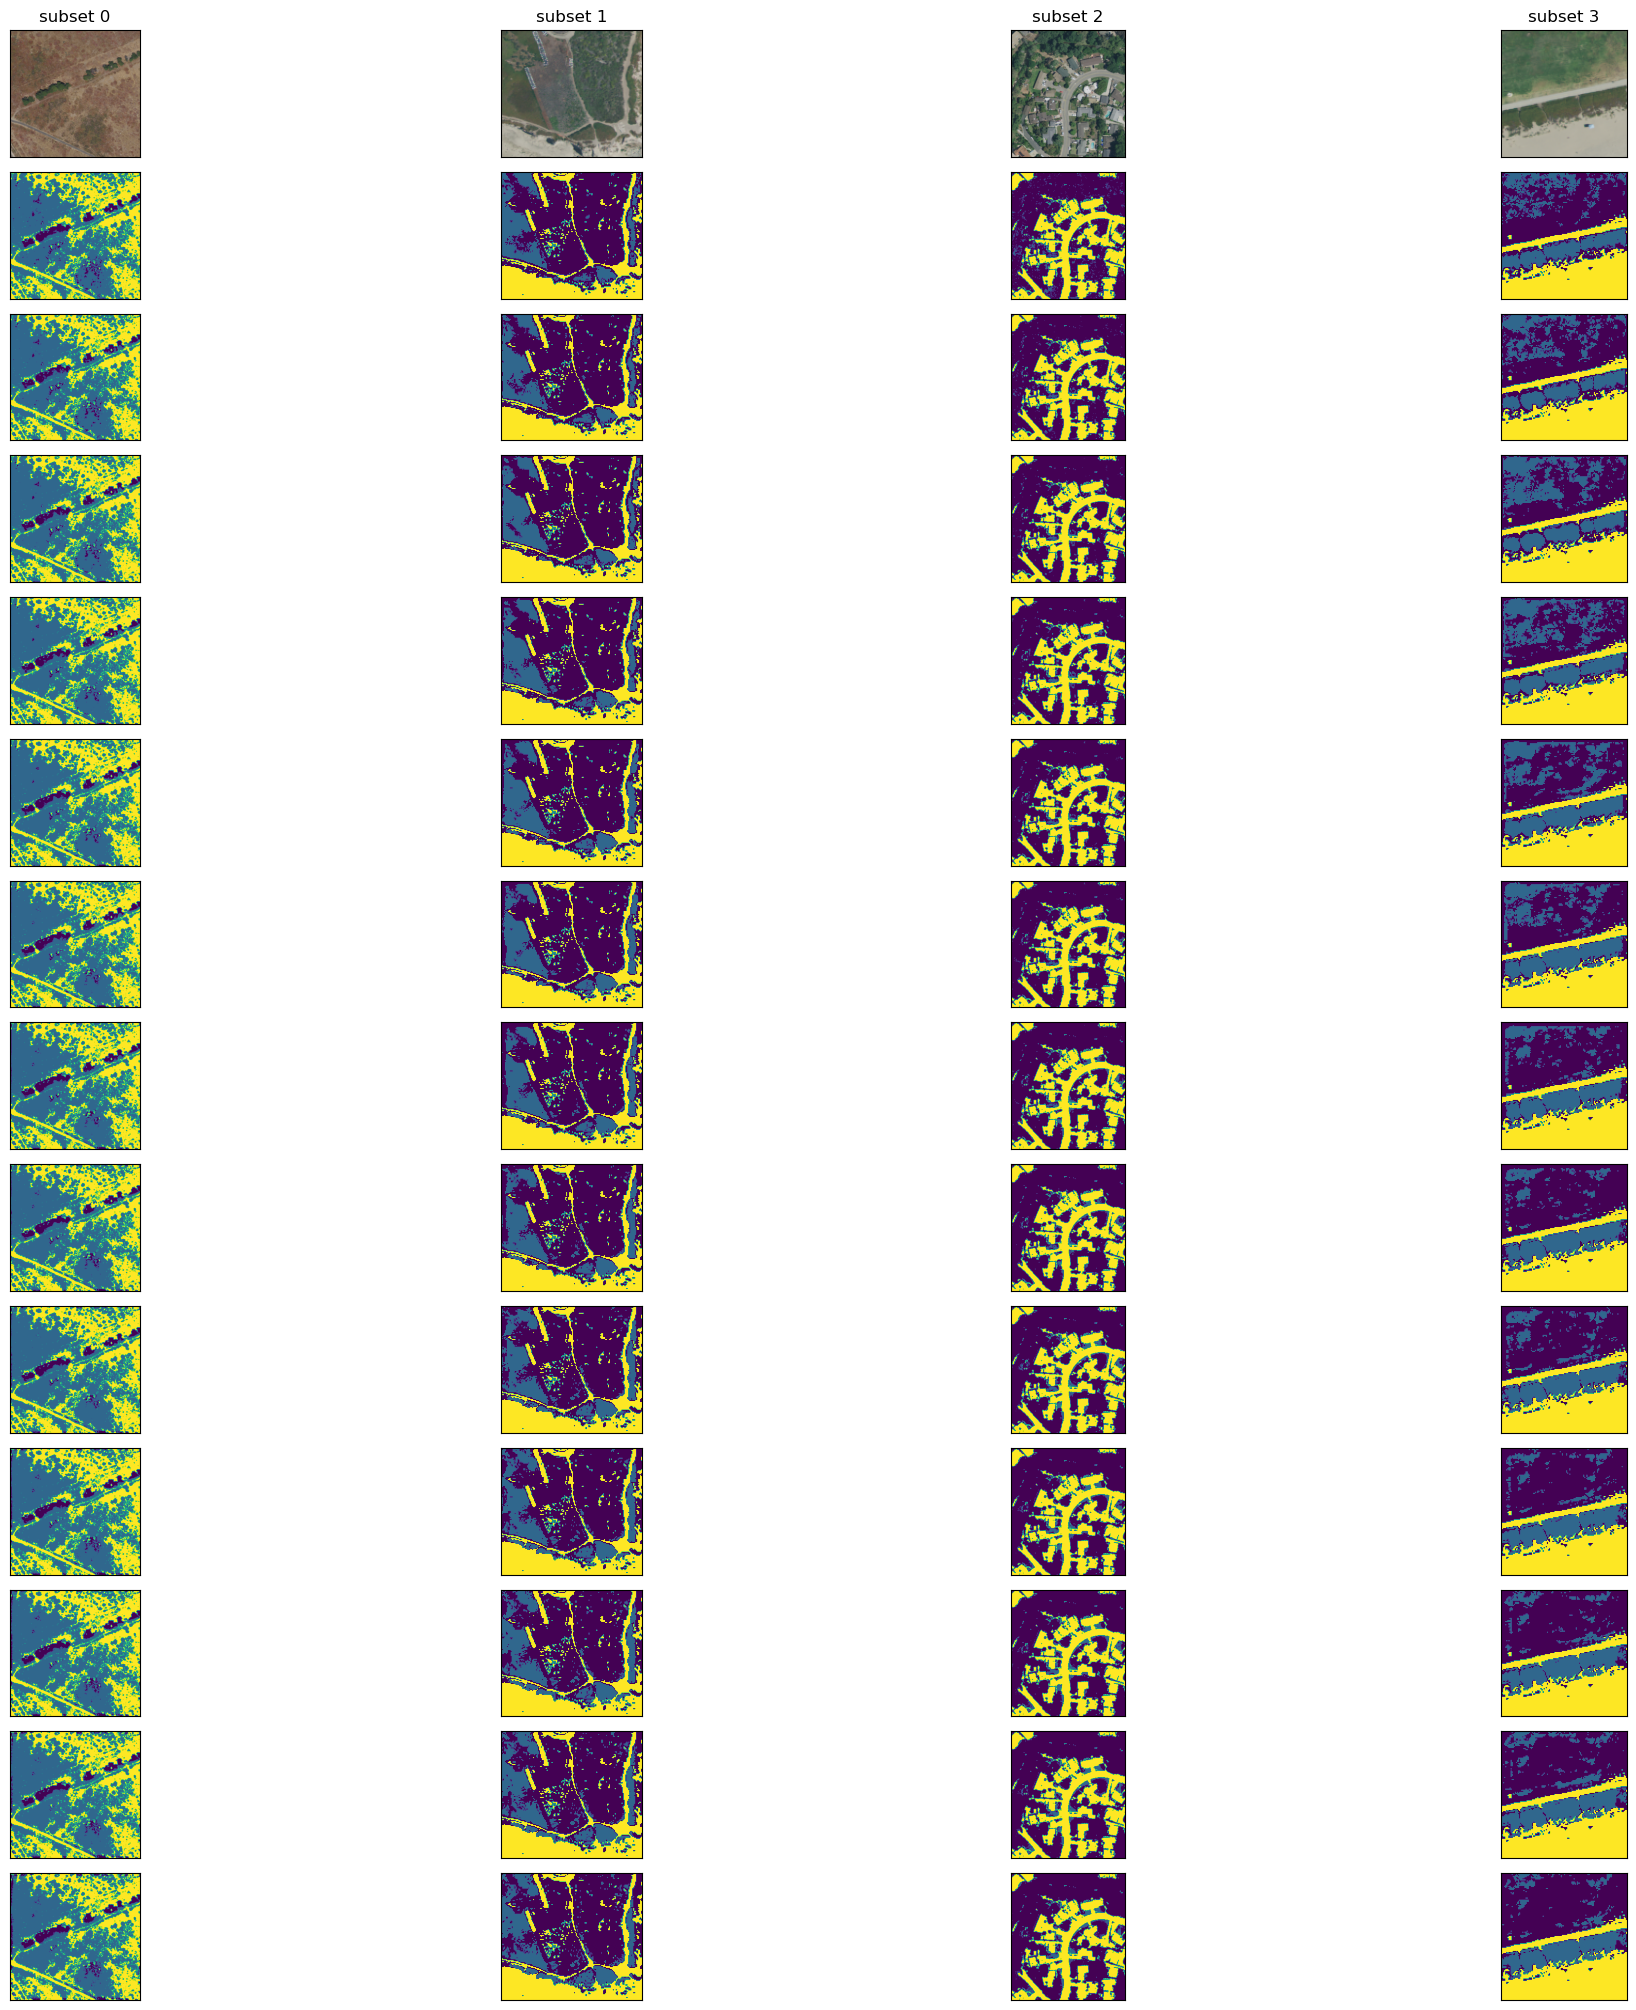

In [50]:
fig, axes = plt.subplots(len(radii)+1,len(rasters),figsize=(20, 20))
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

for j in range(len(rasters)):
    axes[0,j].imshow(np.moveaxis(rasters[j].loc[1:3].to_numpy(),0,-1))
    axes[0,j].set_title('subset ' + str(j+1))

#for i, title in zip(range(len(radii)), feats):
for i in range(len(radii)):
    for j in range(len(rasters)):
        axes[i+1,j].imshow(images[i][j])
#        axes[i+1,j].set_title(title)

#fig.subplots_adjust(wspace=0)
plt.savefig('avg_entr_subset_results.png', bbox_inches='tight')
plt.show()

TO DO: 
 maybe split image into two so they fit in supplementary material
 
 make images for GLCM
 
 select only a few to show in the methods
 
 calculate processing times and make graphs